In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
df_raw = pd.read_csv('daily_cases.csv', index_col='category', parse_dates=True)
df_raw.index.name = 'date'
df_raw.columns = ['cases']

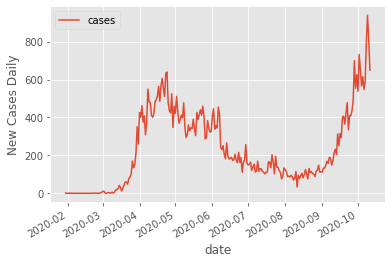

In [3]:
# inspect
df_raw.plot()
plt.ylabel('New Cases Daily')

plt.show()

In [4]:
# find last instance of zero cases
df_raw[df_raw['cases'] == 0].tail()

,cases
date,
2020-02-20,0
2020-02-21,0
2020-02-25,0
2020-02-26,0
2020-03-04,0


C:\Users\remig\anaconda3\envs\PythonCPU\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\remig\anaconda3\envs\PythonCPU\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


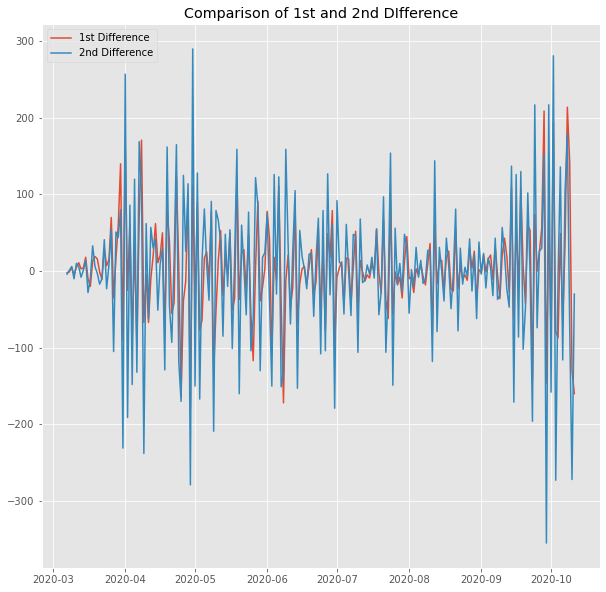

In [5]:
# new data frame of 5 Mar 2020 onwards
df_dates = df_raw.loc['2020-03-05':]

# create columns of first and second differences
df_dates['1st_diff'] = df_dates['cases'].diff()
df_dates['2nd_diff'] = df_dates['cases'].diff().diff()
df_dates = df_dates.dropna()

# inspect first and second differences

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(df_dates['1st_diff'].index, df_dates['1st_diff'], label='1st Difference')
ax.plot(df_dates['2nd_diff'].index, df_dates['2nd_diff'], label='2nd Difference')
ax.set_title('Comparison of 1st and 2nd DIfference')
ax.legend()

plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller

# check for stationarity
dict_pval = {'{}_p_value'.format(col): adfuller(df_dates[col])[1]
             for col in ['1st_diff', '2nd_diff']}

# inspect p-values
dict_pval

{'1st_diff_p_value': 7.477936396471395e-23,
 '2nd_diff_p_value': 8.496439721655389e-11}

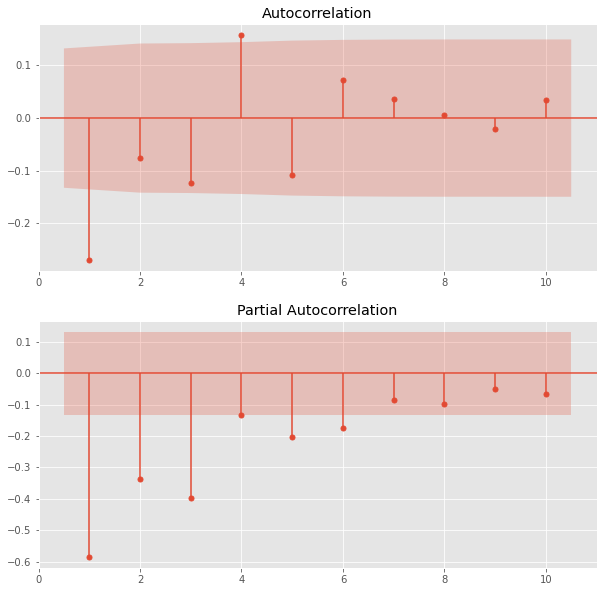

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# use first differences for continued analysis; its p-value sufficiently below 0.05
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
plot_acf(df_dates['1st_diff'], lags=10, zero=False, ax=ax1)
plot_pacf(df_dates['2nd_diff'], lags=10, zero=False, ax=ax2)

plt.show()

In [8]:
# set inferred frequency to daily
df_dates = df_dates.asfreq('D')

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ACF and PACF plots don't give a clear picture as how to set p and q for ARMA model
# use aic and bic values of each trial model, and store in list_vals
list_vals = []

# loop over AR models
for p in range(4):
    
    # loop over MA models
    for q in range(4):
        
        try:
            
            # fit model
            model = SARIMAX(df_dates['cases'], order=(p,1,q), trend='c')
            results = model.fit()

            # append test values to list
            list_vals.append((p, q, results.aic, results.bic))
            
        except:
            
            # if error found, print None for AIC and/or BIC
            list_vals.append((p, q, None, None))
            

# create dataframe and sort by AIC for favourable predictive model
df_pq = pd.DataFrame(list_vals, columns=['p', 'q', 'AIC', 'BIC'])
df_pq.sort_values('AIC').head()

C:\Users\remig\anaconda3\envs\PythonCPU\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\remig\anaconda3\envs\PythonCPU\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\remig\anaconda3\envs\PythonCPU\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\remig\anaconda3\envs\PythonCPU\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


,p,q,AIC,BIC
12,3,0,2399.601814,2416.524289
13,3,1,2400.118194,2420.425164
11,2,3,2400.367087,2424.058553
14,3,2,2402.058813,2425.750278
7,1,3,2403.403907,2423.710877


In [10]:
# p = 3, q = 0
mod = SARIMAX(df_dates['cases'], order=(3,1,0), trend='c')
res = mod.fit()
fc = res.get_prediction(start=-28)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

In [11]:
# inspect
fc_mean.head()

# first day is 2020-09-14

date
2020-09-14    205.970018
2020-09-15    282.139323
2020-09-16    258.341200
2020-09-17    289.046346
2020-09-18    304.989465
Freq: D, Name: predicted_mean, dtype: float64

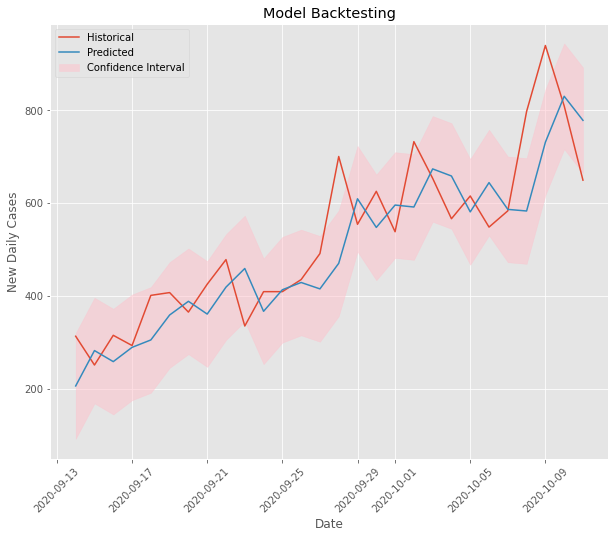

In [12]:
# backtest; compare historical vs. predicted

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(df_dates.loc['2020-09-14':, 'cases'].index, df_dates.loc['2020-09-14':, 'cases'], label='Historical')
ax.plot(fc_mean.index, fc_mean, label='Predicted')
ax.fill_between(fc_mean.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], color='pink', alpha=0.5, label='Confidence Interval')
ax.set_title('Model Backtesting')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Date')
ax.set_ylabel('New Daily Cases')
ax.legend()

plt.show()

In [13]:
# forward predctions
fwd = res.get_forecast(steps=28)
fwd_m = fwd.predicted_mean
fwd_ci = fwd.conf_int()

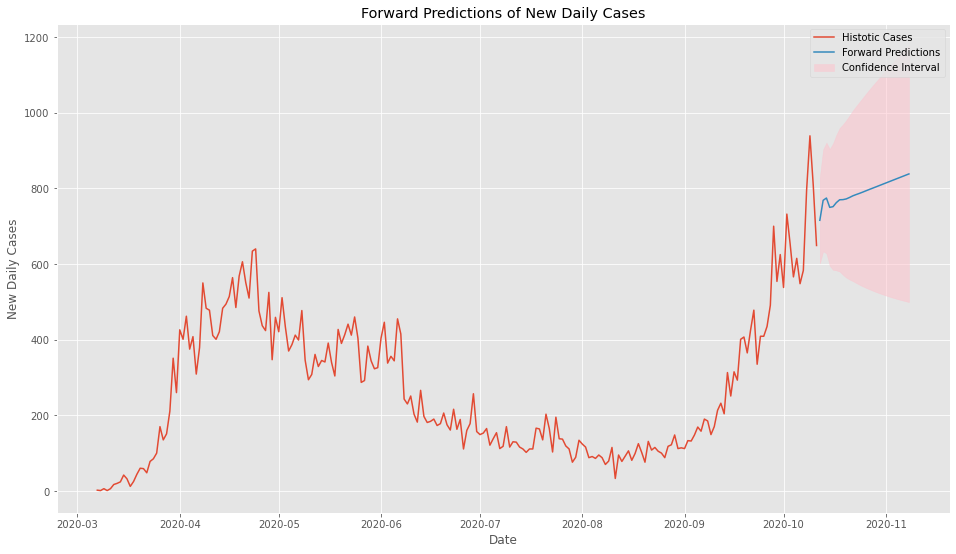

In [14]:
# visualize

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(df_dates['cases'], label='Histotic Cases')
ax.plot(fwd_m.index, fwd_m, label='Forward Predictions')
ax.fill_between(fwd_ci.index, fwd_ci.iloc[:,0], fwd_ci.iloc[:,1], color='pink', alpha=0.5, label='Confidence Interval')
ax.set_xlabel('Date')
ax.set_ylabel('New Daily Cases')
ax.set_title('Forward Predictions of New Daily Cases')
ax.legend()

plt.show()

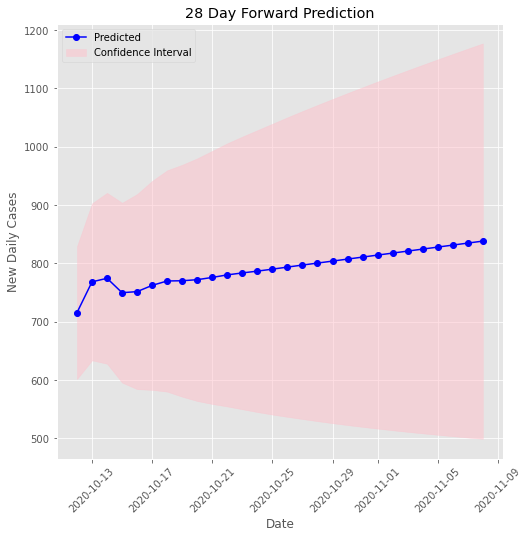

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(fwd_m.index, fwd_m, color='blue', marker='o', label='Predicted')
ax.fill_between(fwd_ci.index, fwd_ci.iloc[:,0], fwd_ci.iloc[:,1], color='pink', alpha=0.5, label='Confidence Interval')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Date')
ax.set_ylabel('New Daily Cases')
ax.set_title('28 Day Forward Prediction')
ax.legend(loc=2)

plt.show()

In [16]:
# forward predictions
fwd_m

2020-10-12    715.636753
2020-10-13    768.426365
2020-10-14    774.475235
2020-10-15    749.784916
2020-10-16    751.662168
2020-10-17    762.340491
2020-10-18    769.890936
2020-10-19    770.273829
2020-10-20    772.104617
2020-10-21    775.968691
2020-10-22    780.339076
2020-10-23    783.667458
2020-10-24    786.786165
2020-10-25    790.136667
2020-10-26    793.693026
2020-10-27    797.161255
2020-10-28    800.555947
2020-10-29    803.953720
2020-10-30    807.389433
2020-10-31    810.827099
2020-11-01    814.253525
2020-11-02    817.674957
2020-11-03    821.100694
2020-11-04    824.528693
2020-11-05    827.955881
2020-11-06    831.381803
2020-11-07    834.807887
2020-11-08    838.234424
Freq: D, Name: predicted_mean, dtype: float64

In [26]:
df_new = pd.read_csv('covid_8_Nov.csv', parse_dates=True, index_col='category')
df_new.index.name = 'date'

In [30]:
df_new_slice = df_new.loc['2020-10-12':,'New cases']
df_new_slice

date
2020-10-12     807
2020-10-13     746
2020-10-14     721
2020-10-15     783
2020-10-16     712
2020-10-17     805
2020-10-18     658
2020-10-19     704
2020-10-20     821
2020-10-21     790
2020-10-22     841
2020-10-23     826
2020-10-24     978
2020-10-25    1042
2020-10-26     851
2020-10-27     827
2020-10-28     834
2020-10-29     934
2020-10-30     896
2020-10-31    1015
2020-11-01     977
2020-11-02     948
2020-11-03    1050
2020-11-04     987
2020-11-05     998
2020-11-06    1003
2020-11-07    1132
2020-11-08    1328
Name: New cases, dtype: int64

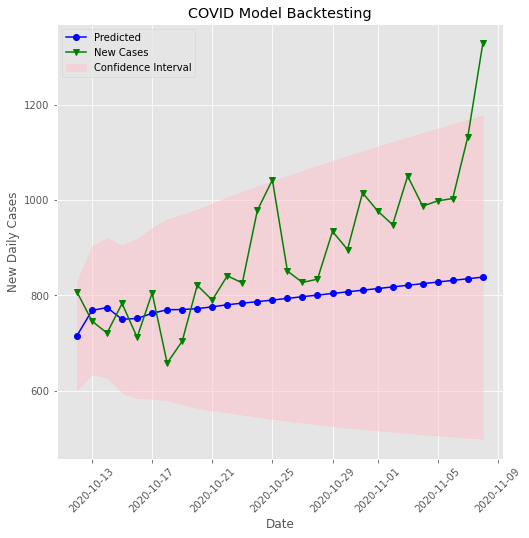

In [34]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(fwd_m.index, fwd_m, color='blue', marker='o', label='Predicted')
ax.fill_between(fwd_ci.index, fwd_ci.iloc[:,0], fwd_ci.iloc[:,1], color='pink', alpha=0.5, label='Confidence Interval')
ax.plot(df_new_slice.index, df_new_slice, color='green', marker='v', label='New Cases')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Date')
ax.set_ylabel('New Daily Cases')
ax.set_title('COVID Model Backtesting')
ax.legend(loc=2)

plt.show()